<a href="https://colab.research.google.com/github/Varun221/Real_time_emotion_detection/blob/master/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# My numpy arrays are stored in google drive. 
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 2. Get the file
def get_file_from_drive(folder_id, file_name):
  file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  for file in file_list:
    if file['title'] == file_name:
      return file['id']
 
 
drive_folder_id = '1oj3k3kGIpqaYfCZpJ2aqV5f3yWzQFeVC'
 
def upload_data_system():
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, 'X_train.npy')})
  downloaded.GetContentFile('X_train.npy') 
 
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, 'Y_train.npy')})
  downloaded.GetContentFile('Y_train.npy')
 
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, 'X_test.npy')})
  downloaded.GetContentFile('X_test.npy')
 
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, 'Y_test.npy')})
  downloaded.GetContentFile('Y_test.npy')
 
 
 
upload_data_system()

In [18]:
# importing the libraries
%tensorflow_version 2.x
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt

In [19]:
# mapping emotion to index
emotion_to_index = {'angry':0,
                   'disgusted':1,
                   'fearful':2,
                   'happy':3,
                   'neutral':4,
                   'sad':5,
                   'surprised':6}
index_to_emotion = {0: 'angry',
                    1: 'disgusted',
                    2: 'fearful',
                    3: 'happy',
                    4: 'neutral',
                    5: 'sad',
                    6: 'surprised'}
 
emotions = list(emotion_to_index.keys())

In [70]:
# Lets load up the files
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
Y_train = np.load('Y_train.npy')
Y_test = np.load('Y_test.npy')
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((28709, 48, 48, 3), (28709, 1), (7178, 48, 48, 3), (7178, 1))

This is happy


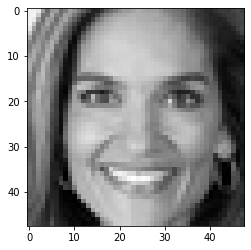

In [71]:
# visualizing the files based on index
index = 1067
img = X_train[index,:,:,:]
print(f"This is {index_to_emotion[Y_train[index, 0]]}")
img = img.astype(np.uint8)
plt.imshow(img, cmap='Greys')
plt.show()

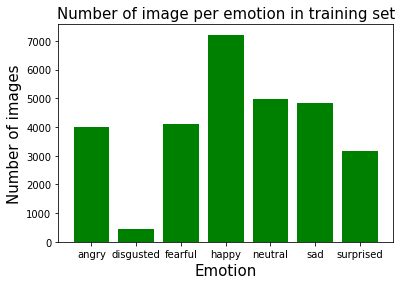

In [72]:
# number of images pertaining to each class
arr = np.zeros((7,))
for i in range(X_train.shape[0]):
    val = np.uint8(Y_train[i])
    arr[val] = arr[val] + 1
#for i in range(7):
#  print(f"{index_to_emotion[i]} has {arr[i,0]}")
arr2 = np.reshape(arr, (-1))
plt.bar([0,1,2,3,4,5,6], arr2, color='green')
plt.xlabel("Emotion", fontsize = 15)
plt.ylabel("Number of images", fontsize = 15)
plt.title("Number of image per emotion in training set", fontsize=15)
 
plt.xticks([0,1,2,3,4,5,6], emotions)
 
plt.show()

As we can see, the number of images for the emotion disgust is quite low and the distribution for images is not quite same. Hence we will be using f1 score of model as an evaluation metric.

In [73]:
# preproceesing the images
# scaling the X arrays
X_train_proc = X_train/255.
X_test_proc = X_test/255.
# one hot encoding the Y arrays
Y_train_proc = np.squeeze(np.array(tf.one_hot(Y_train,7, axis=1)))
Y_test_proc = np.squeeze(np.array(tf.one_hot(Y_test,7, axis=1)))
Y_train_proc.shape, Y_test_proc.shape

((28709, 7), (7178, 7))

In [74]:
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, Input

In [76]:
input = Input(shape=(48,48,3))
x = Conv2D(16, (5,5), activation='relu')(input)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), strides=2)(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (5,5), activation='relu')(x)
x = MaxPooling2D((3,3), strides=2)(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (4,4), activation='relu')(x)
x = Flatten()(x)
x = Dense(40, activation='relu')(x)
output = Dense(7, activation='softmax')(x)
model = Model(inputs=input, outputs=output)

In [77]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 44, 44, 16)        1216      
_________________________________________________________________
batch_normalization_9 (Batch (None, 44, 44, 16)        64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 17, 17, 32)        12832     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 32)          0   

In [78]:
# compiling the model with adam optimizer
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001, decay=0.0001 / 40)
 
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.Precision(),
                                                                           tf.keras.metrics.Recall(),
                                                                           'accuracy'])

In [79]:
history = model.fit(X_train_proc, Y_train_proc, epochs=30, verbose=1, validation_data=(X_test_proc, Y_test_proc))

Epoch 1/30
898/898 [==============================] - 12s 13ms/step - loss: 1.7322 - precision_7: 0.6238 - recall_7: 0.0328 - accuracy: 0.3036 - val_loss: 1.5999 - val_precision_7: 0.7661 - val_recall_7: 0.0548 - val_accuracy: 0.3948
Epoch 2/30
898/898 [==============================] - 11s 12ms/step - loss: 1.5687 - precision_7: 0.6856 - recall_7: 0.1272 - accuracy: 0.3924 - val_loss: 1.4985 - val_precision_7: 0.7816 - val_recall_7: 0.1371 - val_accuracy: 0.4369
Epoch 3/30
898/898 [==============================] - 11s 13ms/step - loss: 1.4987 - precision_7: 0.7033 - recall_7: 0.1704 - accuracy: 0.4206 - val_loss: 1.4474 - val_precision_7: 0.7870 - val_recall_7: 0.1631 - val_accuracy: 0.4465
Epoch 4/30
898/898 [==============================] - 11s 13ms/step - loss: 1.4367 - precision_7: 0.7201 - recall_7: 0.2048 - accuracy: 0.4480 - val_loss: 1.4138 - val_precision_7: 0.7894 - val_recall_7: 0.1921 - val_accuracy: 0.4645
Epoch 5/30
898/898 [==============================] - 11s 13ms/s

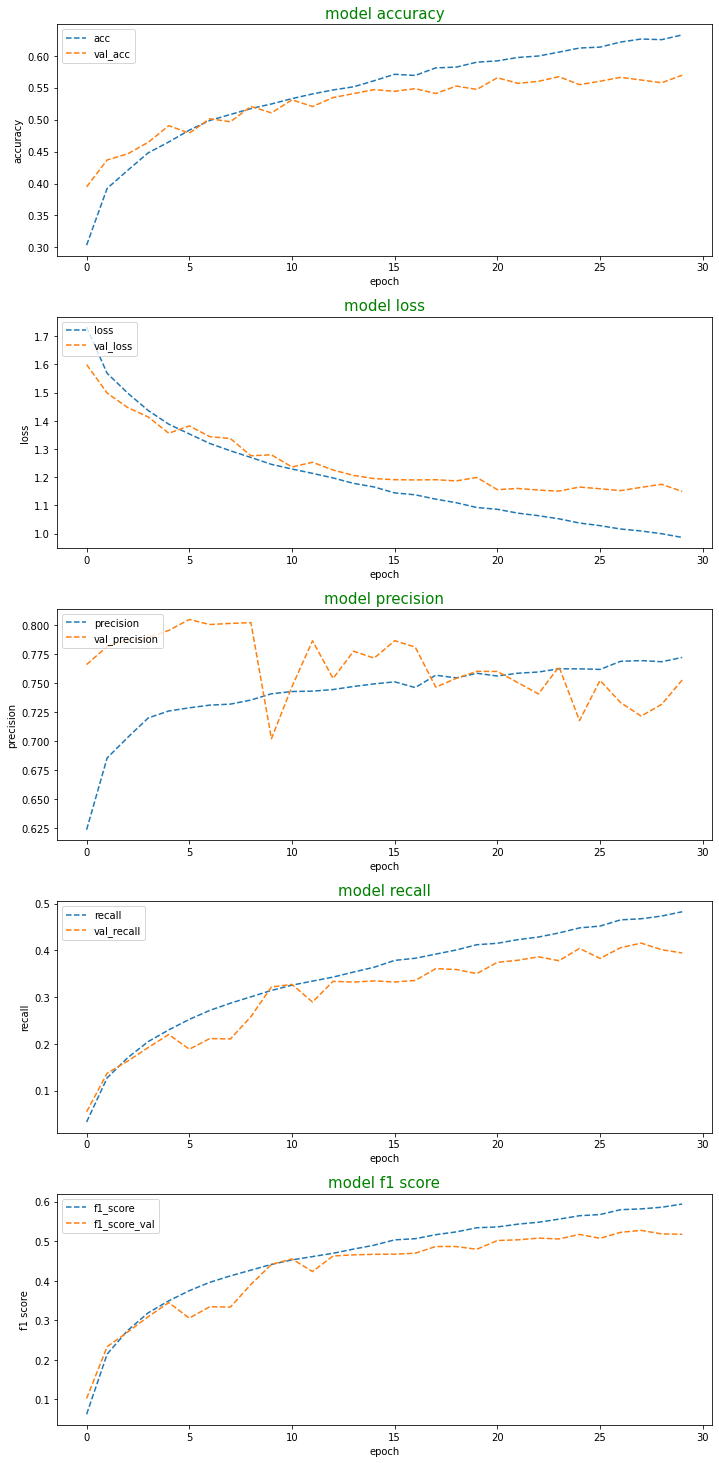

In [80]:
# PLOTTING TRAINING RESULTS
# plotting accuracy, loss, recall, precision and f1 score of training and validation sets
 
num = 7
prec = f"precision_{num}"
rec = f"recall_{num}"
valprec = f"val_precision_{num}"
valrec = f"val_recall_{num}"
 
 
plt.figure(figsize=(10,20))
 
plt.subplot(511)
plt.plot(history.history['accuracy'], '--', label='acc')
plt.plot(history.history['val_accuracy'], '--',label='val_acc')
plt.title('model accuracy',fontsize=15, color='green')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
#axes.set_ylim([0.965, 1])
plt.tight_layout(h_pad=3.0)
 
 
plt.subplot(512)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.subplot(513)
plt.plot(history.history[prec], '--', label='precision')
plt.plot(history.history[valprec], '--',label='val_precision')
plt.title('model precision',fontsize=15, color='green')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.subplot(514)
plt.plot(history.history[rec], '--', label='recall')
plt.plot(history.history[valrec], '--',label='val_recall')
plt.title('model recall',fontsize=15, color='green')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
precision = history.history[prec]
recall = history.history[rec]
precval = history.history[valprec]
recval = history.history[valrec]
f1 = [(2*a*b)/(a+b) for a,b in zip(precision, recall)]
f1_val = [(2*a*b)/(a+b+1e-7) for a,b in zip(precval, recval)]
 
plt.subplot(515)
plt.plot(f1, '--', label='f1_score')
plt.plot(f1_val, '--',label='f1_score_val')
plt.title('model f1 score',fontsize=15,color='green')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.show()

In [81]:
# classification reports and confusion matrix
from sklearn.metrics import classification_report
print('\nClassification Report\n')
preds = model.predict(X_test_proc)
y_pred = np.argmax(preds, axis=1)
print(classification_report(Y_test, y_pred, target_names=emotions))
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)


Classification Report

              precision    recall  f1-score   support

       angry       0.45      0.53      0.48       958
   disgusted       0.56      0.28      0.37       111
     fearful       0.48      0.28      0.35      1024
       happy       0.73      0.82      0.77      1774
     neutral       0.47      0.60      0.53      1233
         sad       0.47      0.36      0.40      1247
   surprised       0.72      0.75      0.73       831

    accuracy                           0.57      7178
   macro avg       0.55      0.52      0.52      7178
weighted avg       0.56      0.57      0.56      7178

Confusion Matrix

[[ 503    9   70   90  158  102   26]
 [  45   31    9    9   10    5    2]
 [ 152    5  284   91  195  176  121]
 [  65    0   38 1461  120   62   28]
 [ 134    5   46  120  745  148   35]
 [ 199    3   87  168  315  444   31]
 [  26    2   53   62   52   16  620]]


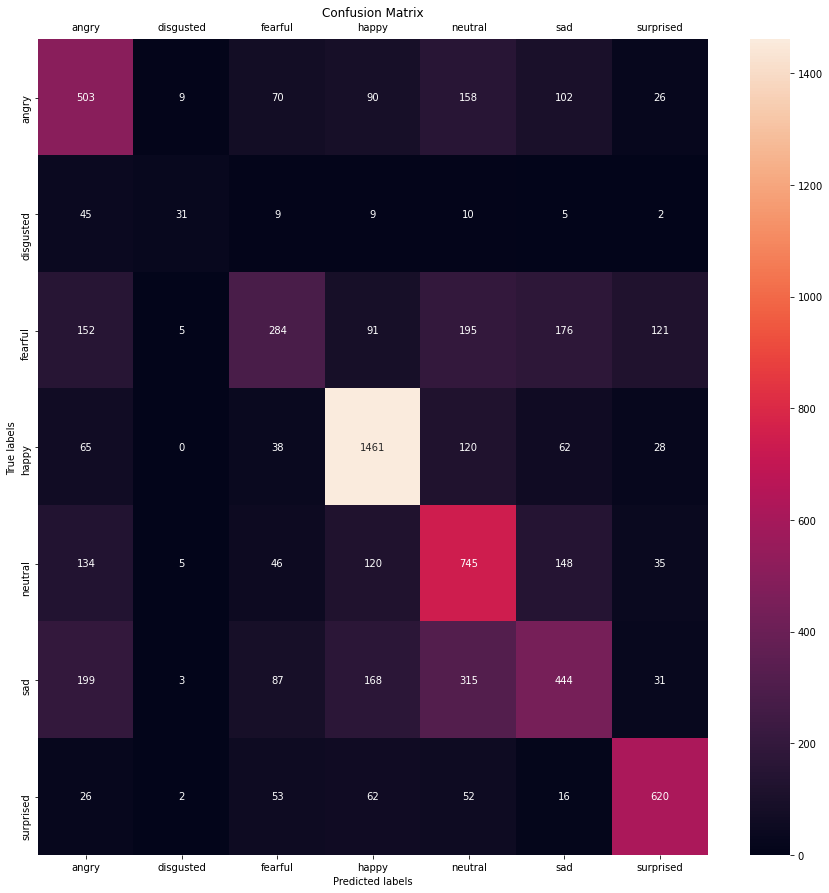

In [82]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     
 
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
ax.xaxis.set_tick_params(labeltop='on')
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
rev = []
for i in range(6,-1,-1):
  rev.append(emotions[i])
ax.xaxis.set_ticklabels(emotions); 
 
ax.yaxis.set_ticklabels(emotions);

In [83]:
# saving the model
model.save('my_model.h5')